In [22]:
# import the libraries
import torch
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import cv2      # open CV
import pandas as pd
import numpy as np

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device '+str(device))
print( torch. __version__)

Using device cuda
2.1.1


### We choose GoogLeNet as our model, see more: https://paperswithcode.com/method/googlenet

In [24]:
# Define your model
from torchvision.models import squeezenet1_1
from torchvision.models import googlenet
model = googlenet(pretrained=True).eval().to(device)

d:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Test set image preprocessing-RCTN

In [25]:
from torchvision import transforms
# Scale, Crop, Turn Tensor, Normalize
test_transform = transforms.Compose([transforms.Resize(256),
                            transforms.CenterCrop(224),
                            transforms.ToTensor(),
                            transforms.Normalize(
                                mean=[0.485, 0.456, 0.406], 
                                std=[0.229, 0.224, 0.225])
                        ])

In [26]:
# test image
img_path = 'test_img/1280.jpg'

In [27]:
# image preprocessing
img_pil = Image.open(img_path)
input_tensor = test_transform(img_pil).unsqueeze(0).to(device)

In [28]:
input_tensor.shape

torch.Size([1, 3, 224, 224])

In [29]:
from torchinfo import summary

## Check layers after changing layers
summary(model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
GoogLeNet (GoogLeNet)                    [32, 3, 224, 224]    [32, 1000]           --                   True
├─BasicConv2d (conv1)                    [32, 3, 224, 224]    [32, 64, 112, 112]   --                   True
│    └─Conv2d (conv)                     [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
│    └─BatchNorm2d (bn)                  [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
├─MaxPool2d (maxpool1)                   [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─BasicConv2d (conv2)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   True
│    └─Conv2d (conv)                     [32, 64, 56, 56]     [32, 64, 56, 56]     4,096                True
│    └─BatchNorm2d (bn)                  [32, 64, 56, 56]     [32, 64, 56, 56]     128                  True
├─BasicConv2d (c

### Let pre-trained model classify our image

In [30]:
# Set your CAM extractor
from torchcam.methods import CAM, GradCAM, GradCAMpp, ISCAM, LayerCAM, SSCAM, ScoreCAM, SmoothGradCAMpp, XGradCAM
# CAM GradCAM GradCAMpp ISCAM LayerCAM SSCAM ScoreCAM SmoothGradCAMpp XGradCAM
target_layer = model.inception5b
cam_extractor = GradCAM(model, target_layer)

In [31]:
pred_logits = model(input_tensor) # The output has unnormalized scores.
pred_logits.shape

torch.Size([1, 1000])

In [32]:
# choose top n probabilities
n = 1
pred_top_n = torch.topk(pred_logits, n) # returns the k largest elements of the given input tensor long a given dimension.
print(pred_top_n)
pred_ids = pred_top_n[1].detach().cpu().numpy().squeeze().item()
pred_ids


torch.return_types.topk(
values=tensor([[5.9835]], device='cuda:0', grad_fn=<TopkBackward0>),
indices=tensor([[47]], device='cuda:0'))


47

In [33]:
# calculate confidences
confs = pred_top_n[0].cpu().detach().numpy().squeeze()

#### Load ImageNet 1000 classifications labels

In [34]:
df = pd.read_csv('imagenet_class_index.csv')
# df = pd.read_csv('imagenet_class_index.csv)..drop(['Chinese'], axis=1)

In [35]:
# check this classes
df

,ID,class,wordnet,Chinese
0,0,tench,n01440764,丁鲷
1,1,goldfish,n01443537,金鱼
2,2,great_white_shark,n01484850,大白鲨
3,3,tiger_shark,n01491361,虎鲨
4,4,hammerhead,n01494475,锤头鲨
...,...,...,...,...
995,995,earthstar,n13044778,地星（菌类）
996,996,hen-of-the-woods,n13052670,多叶奇果菌
997,997,bolete,n13054560,牛肝菌
998,998,ear,n13133613,玉米穗


### CAM

In [36]:
from torchcam.utils import overlay_mask

activation_map_raw = cam_extractor(pred_ids, pred_logits)
activation_map = activation_map_raw[0][0].detach().cpu().numpy()
result = overlay_mask(img_pil, Image.fromarray(activation_map), alpha=0.7) # overlay a colormapped mask on a background image

### Write results of classification on the image

In [37]:
# use openCV to load image
img_bgr = cv2.imread(img_path)

In [38]:
# load labels
df = pd.read_csv('imagenet_class_index.csv')
idx_to_labels = {}
idx_to_labels_cn = {}
for idx, row in df.iterrows():
    idx_to_labels[row['ID']] = row['class']
    idx_to_labels_cn[row['ID']] = row['Chinese']

In [39]:
# check labels
idx_to_labels

{0: 'tench',
 1: 'goldfish',
 2: 'great_white_shark',
 3: 'tiger_shark',
 4: 'hammerhead',
 5: 'electric_ray',
 6: 'stingray',
 7: 'cock',
 8: 'hen',
 9: 'ostrich',
 10: 'brambling',
 11: 'goldfinch',
 12: 'house_finch',
 13: 'junco',
 14: 'indigo_bunting',
 15: 'robin',
 16: 'bulbul',
 17: 'jay',
 18: 'magpie',
 19: 'chickadee',
 20: 'water_ouzel',
 21: 'kite',
 22: 'bald_eagle',
 23: 'vulture',
 24: 'great_grey_owl',
 25: 'European_fire_salamander',
 26: 'common_newt',
 27: 'eft',
 28: 'spotted_salamander',
 29: 'axolotl',
 30: 'bullfrog',
 31: 'tree_frog',
 32: 'tailed_frog',
 33: 'loggerhead',
 34: 'leatherback_turtle',
 35: 'mud_turtle',
 36: 'terrapin',
 37: 'box_turtle',
 38: 'banded_gecko',
 39: 'common_iguana',
 40: 'American_chameleon',
 41: 'whiptail',
 42: 'agama',
 43: 'frilled_lizard',
 44: 'alligator_lizard',
 45: 'Gila_monster',
 46: 'green_lizard',
 47: 'African_chameleon',
 48: 'Komodo_dragon',
 49: 'African_crocodile',
 50: 'American_alligator',
 51: 'triceratops',
 

In [40]:
from PIL import Image, ImageDraw, ImageFont

font_size = 40
font = ImageFont.truetype("arial.ttf", font_size)

draw = ImageDraw.Draw(result)
text_pred = 'Pred Class: {}'.format(idx_to_labels[pred_ids])
draw.text((50, 100), text_pred, font=font, fill=(255, 0, 0, 1))

### Show results

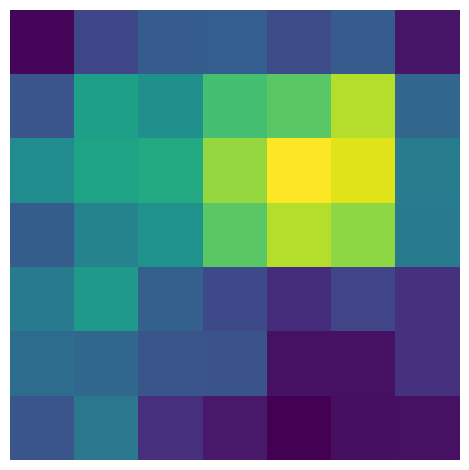

In [41]:
import matplotlib.pyplot as plt
# visualize the raw CAM
plt.imshow(activation_map_raw[0].squeeze(0).cpu().numpy()); plt.axis('off'); plt.tight_layout(); plt.show()

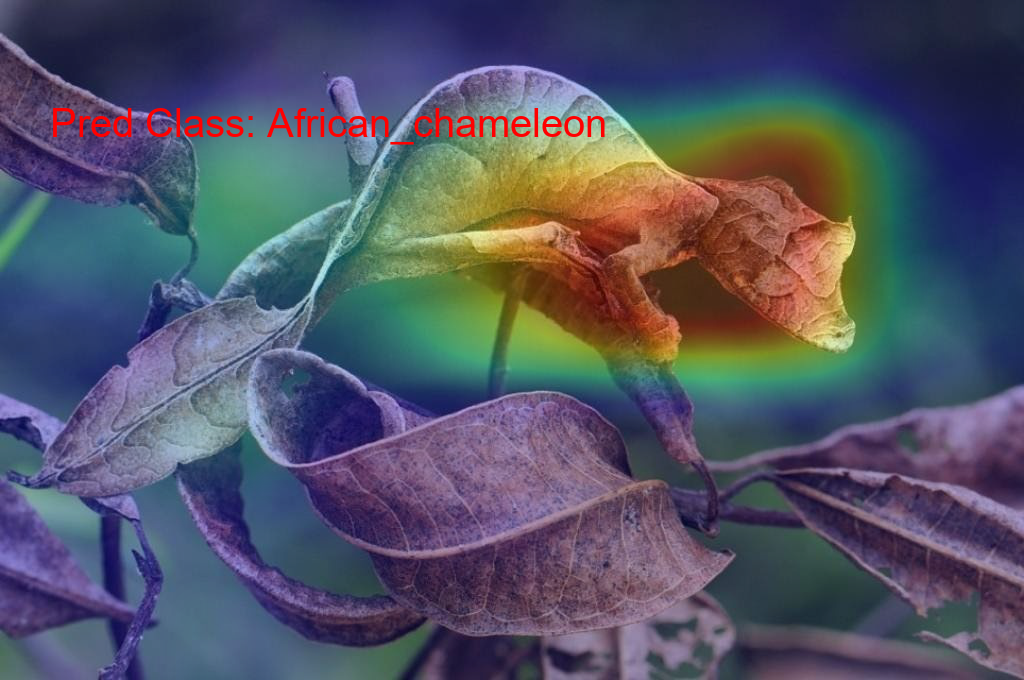

In [42]:
# check result
result

### How's a worse model ?

d:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


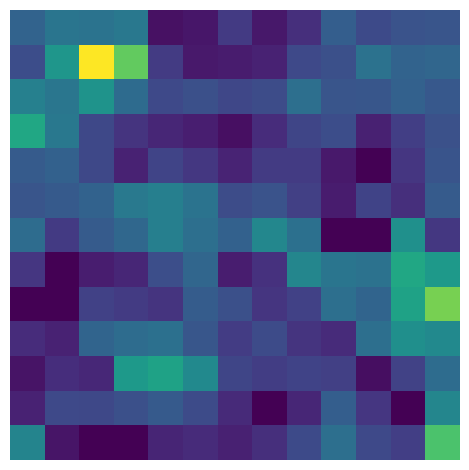

In [43]:
model = squeezenet1_1(pretrained=True).eval().to(device)
cam_extractor = GradCAM(model)
pred_logits = model(input_tensor) # The output has unnormalized scores.
pred_logits.shape

# choose top n probabilities
n = 1
pred_top_n = torch.topk(pred_logits, n) # returns the k largest elements of the given input tensor long a given dimension.

pred_ids = pred_top_n[1].detach().cpu().numpy().squeeze().item()
pred_ids

# calculate confidences
confs = pred_top_n[0].cpu().detach().numpy().squeeze()

activation_map_raw = cam_extractor(pred_ids, pred_logits)
activation_map = activation_map_raw[0][0].detach().cpu().numpy()
result = overlay_mask(img_pil, Image.fromarray(activation_map), alpha=0.7) # overlay a colormapped mask on a background image

img_bgr = cv2.imread(img_path)

# load labels
df = pd.read_csv('imagenet_class_index.csv')
idx_to_labels = {}
idx_to_labels_cn = {}
for idx, row in df.iterrows():
    idx_to_labels[row['ID']] = row['class']
    idx_to_labels_cn[row['ID']] = row['Chinese']

font_size = 40
font = ImageFont.truetype("arial.ttf", font_size)

draw = ImageDraw.Draw(result)
text_pred = 'Pred Class: {}'.format(idx_to_labels[pred_ids])
draw.text((50, 100), text_pred, font=font, fill=(255, 0, 0, 1))

# visualize the raw CAM
plt.imshow(activation_map_raw[0].squeeze(0).cpu().numpy()); plt.axis('off'); plt.tight_layout(); plt.show()

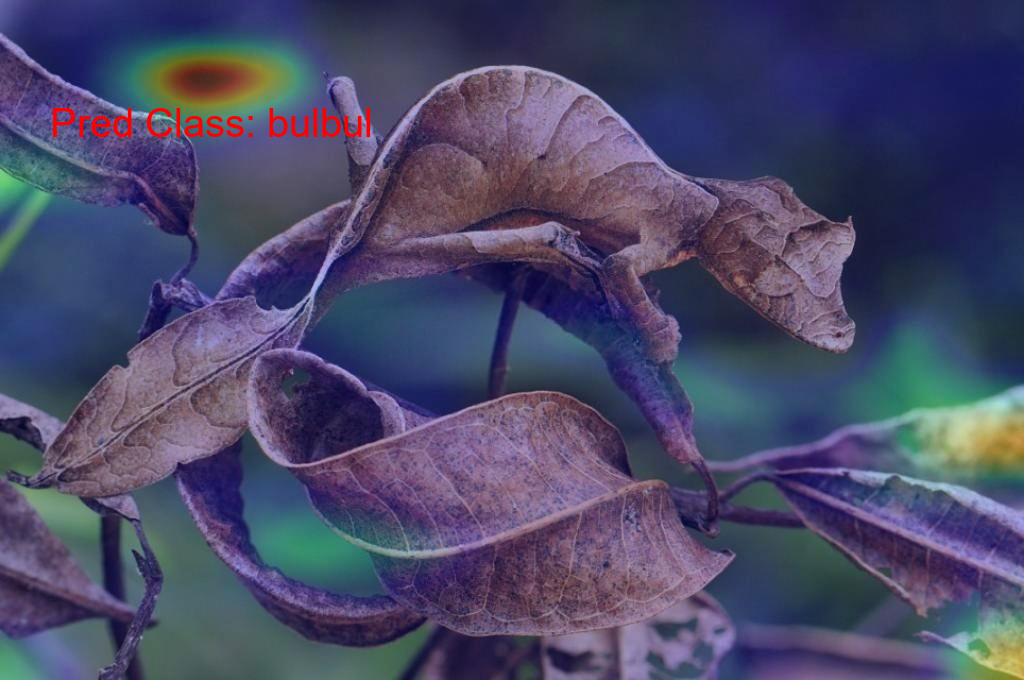

In [44]:
# check result
result